In [5]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
from keras.models import Model,Sequential
from keras import optimizers
from keras.layers import Input,Conv1D,BatchNormalization,MaxPooling1D,LSTM,Dense,Activation,Layer,Conv2D,MaxPooling2D,Flatten,Reshape
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.utils import to_categorical
import keras.backend as K
import argparse
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import librosa.display

# 举例

In [ ]:
lujing1 = "/content/drive/MyDrive/test/03a02Fc.wav"
sig1, fs1 = librosa.load(lujing1, sr=16000)
lujing = "/content/drive/MyDrive/test/03a04Ta.wav"
sig2, fs2 = librosa.load(lujing, sr=16000)
print(sig1)
print(fs1)
print(sig2)
print(fs2)

[0.0007019  0.00250244 0.00268555 ... 0.00024414 0.00015259 0.        ]
16000
[0.00039673 0.00039673 0.00039673 ... 0.         0.00039673 0.        ]
16000


Text(0, 0.5, 'Amplitude')

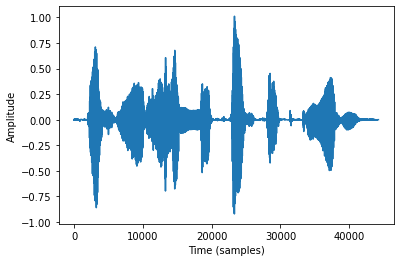

In [ ]:
import matplotlib.pyplot as plt
y,sr = librosa.load('/content/drive/MyDrive/test/03a02Fc.wav')
plt.plot(y)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

Text(0.5, 1.0, 'Spectrogram')

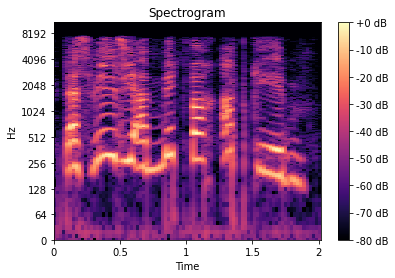

In [ ]:
 spec = np.abs(librosa.stft(y, hop_length=512))
 spec = librosa.amplitude_to_db(spec, ref=np.max)
 librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
 plt.colorbar(format='%+2.0f dB')
 plt.title('Spectrogram')

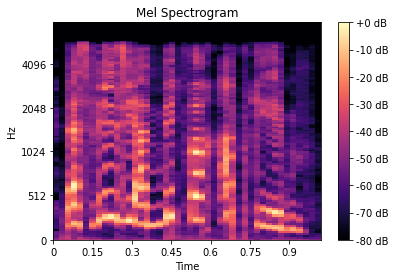

In [ ]:
 mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
 mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
 librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
 plt.title('Mel Spectrogram')
 plt.colorbar(format='%+2.0f dB')

# 数据处理

In [52]:
print(os.listdir("drive/MyDrive/dataset"))

['erkennung.txt', 'erklaerung.txt', 'download.zip', 'lablaut', 'labsilb', 'wav', 'silb']


In [6]:

datapath = "drive/MyDrive/dataset/wav"
classes = np.array(['W','L','E','A','F','T','N']) # 7 classes

Seconds_per_sample = 1 # The sample size in seconds
Padded_sample = True # Whether to take samples which are less than the required length
fs = 16000 # Sampling Frequency of Input data
seg_len = int((Seconds_per_sample)*16000) # signal split length (in samples) in time domain
seg_ov = int(seg_len*0.5) # 50% overlap

In [49]:
print("你好")

你好


In [7]:
def normalize(s):
# RMS normalization
    new_s = s/np.sqrt(np.sum(np.square((np.abs(s))))/len(s))
    return new_s
def countclasses(fnames):
    dict = {classes[0]:0,classes[1]:0,classes[2]:0,classes[3]:0,classes[4]:0,classes[5]:0,classes[6]:0}
    for name in fnames:
        if name[5] in classes:
            dict[name[5]]+=1
    return dict
def data1d(path):
    fnames = os.listdir(datapath) # fnames = os.listdir(datapath)
    dict = countclasses(fnames)
    print('Total Data', dict)
    num_cl = len(classes)
    train_dict = {classes[0]: 0, classes[1]: 0, classes[2]:0, classes[3]: 0, classes[4]: 0, classes[5]: 0,
                      classes[6]: 0}
    test_dict = {classes[0]: 0, classes[1]: 0, classes[2]: 0, classes[3]: 0, classes[4]: 0, classes[5]: 0,
                     classes[6]: 0}
    val_dict = {classes[0]: 0, classes[1]: 0, classes[2]: 0, classes[3]: 0, classes[4]: 0, classes[5]: 0, classes[6]: 0}
    for i in range(num_cl):
        cname = list(dict.keys())[i]
        cnum = dict[cname]
        t = round(0.8*cnum)
        test_dict[cname] = int(cnum-t)
        val_dict[cname] = int(round(0.2*t))
        train_dict[cname] = int(t - val_dict[cname])
        print('Class:', cname, 'train:', train_dict[cname], 'val:', val_dict[cname], 'test:', test_dict[cname])
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    x_val = []
    y_val = []
    count = {classes[0]: 0, classes[1]: 0, classes[2]: 0, classes[3]: 0, classes[4]: 0, classes[5]: 0, classes[6]: 0}
    loop = 1
    for name in fnames:
        if name[5] in classes:
            sig, fs = librosa.load(datapath + '/' + name, sr=16000)
            if loop > 0:
                loop = -1
                print("First File: ", name)
                print("Audio Signals approximate Lengths: ", sig.shape)
            data = normalize(sig)
            if (len(data) < seg_len):
                pad_len = int(seg_len - len(data))
                pad_rem = int(pad_len % 2)
                pad_len /= 2
                signal = np.pad(data, (int(pad_len), int(pad_len + pad_rem)), 'constant', constant_values=0)
            elif (len(data) > seg_len):
                signal = []
                end = seg_len
                st = 0
                while (end < len(data)):
                    signal.append(data[st:end])
                    st = st + seg_ov
                    end = st + seg_len
                signal = np.array(signal)
                if (end >= len(data)):
                    num_zeros = int(end - len(data))
                    if (num_zeros > 0):
                        n1 = np.array(data[st:end])
                        n2 = np.zeros([num_zeros])
                        s = np.concatenate([n1, n2], 0)
                    else:
                        s = np.array(data[int(st):int(end)])
                signal = np.vstack([signal, s])
            else:
                signal = data
            if (count[name[5]] < train_dict[name[5]]):
                if (signal.ndim > 1):
                    for i in range(signal.shape[0]):
                        x_train.append(signal[i])
                        y_train.append(name[5])
                else:
                    x_train.append(signal)
                    y_train.append(name[5])
            else:
                if ((count[name[5]] - train_dict[name[5]]) < val_dict[name[5]]):
                    if (signal.ndim > 1):
                        for i in range(signal.shape[0]):
                            x_val.append(signal[i])
                            y_val.append(name[5])
                    else:
                        x_val.append(signal)
                        y_val.append(name[5])
                else:
                    if (signal.ndim > 1):
                        for i in range(signal.shape[0]):
                            x_test.append(signal[i])
                            y_test.append(name[5])
                    else:
                        x_test.append(signal)
                        y_test.append(name[5])
            count[name[5]] += 1
    return np.float32(x_train), y_train, np.float32(x_test), y_test, np.float32(x_val), y_val
    

In [8]:

def string2num(y):
    y1 = []
    for i in y:
        if (i==classes[0]):
            y1.append(0)
        elif (i==classes[1]):
            y1.append(1)
        elif (i==classes[2]):
            y1.append(2)
        elif (i==classes[3]):
            y1.append(3)
        elif (i==classes[4]):
            y1.append(4)
        elif (i==classes[5]):
            y1.append(5)
        else:
            y1.append(6)
    y1 = np.float32(np.array(y1))
    return y1

def load_data():
    x_tr, y_tr, x_t, y_t, x_v, y_v = data1d(datapath)
    y_tr = string2num(y_tr)
    y_t = string2num(y_t)
    y_v = string2num(y_v)
    return x_tr, y_tr, x_t, y_t, x_v, y_v

# xd_tr,yd_tr,xd_t,yd_t,xd_val,yd_val = load_data()
xd_tr,yd_tr,xd_t,yd_t,xd_val,yd_val = load_data()

Total Data {'W': 127, 'L': 80, 'E': 46, 'A': 67, 'F': 69, 'T': 61, 'N': 78}
Class: W train: 82 val: 20 test: 25
Class: L train: 51 val: 13 test: 16
Class: E train: 30 val: 7 test: 9
Class: A train: 43 val: 11 test: 13
Class: F train: 44 val: 11 test: 14
Class: T train: 39 val: 10 test: 12
Class: N train: 50 val: 12 test: 16
First File:  16a02Nb.wav
Audio Signals approximate Lengths:  (26567,)


# *1D CNN LSTM model*

In [53]:
def emo1d(input_shape, num_classes,args):
    model = Sequential(name='Emo1D')

# LFLB1
    model.add(Conv1D(filters = 64,kernel_size = (3),strides=1,padding='same',data_format='channels_last',input_shape=input_shape, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))	
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size = 4, strides = 4))

#LFLB2
    model.add(Conv1D(filters=64, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size = 4, strides = 4))

#LFLB3
    model.add(Conv1D(filters=128, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size = 4, strides = 4))

#LFLB4
    model.add(Conv1D(filters=128, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size = 4, strides = 4))

#LSTM
    model.add(LSTM(units=args.num_fc, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))) 

#FC
    # model.add(Dropout(rate=0.5))
    model.add(Dense(units=100,activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    # model.add(Dropout(rate=0.5))
    model.add(Dense(units=7,activation='softmax'))


#Model compilation	
    opt = optimizers.SGD(lr = args.learning_rate, decay=args.decay, momentum=args.momentum, nesterov=True)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model

# 第一次运行

In [ ]:
def train(model, x_tr, y_tr, x_val, y_val, args):
    es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=8)
    mc = ModelCheckpoint('best_model_1D_CNN.h5', monitor='val_categorical_accuracy', mode='max',verbose=1,save_best_only=True)
    history = model.fit(x_tr, y_tr, epochs=args.num_epochs, batch_size=args.batch_size, validation_data=(x_val, y_val),
                        callbacks=[es, mc])
    
    
    return model
def test(model,x_t,y_t):

    saved_model = load_model('best_model_1D_CNN.h5')
    score = saved_model.evaluate(x_t,y_t,batch_size=20)
    print(score)
    return score
def loadData1d(x_tr,y_tr,x_t,y_t,x_val,y_val):
    x_tr = x_tr.reshape(-1,x_tr.shape[1],1)
    x_t = x_t.reshape(-1,x_t.shape[1],1)
    x_val = x_val.reshape(-1,x_val.shape[1],1)
    y_tr = to_categorical(y_tr)
    y_t = to_categorical(y_t)
    y_val = to_categorical(y_val)
    return x_tr,y_tr,x_t,y_t,x_val,y_val
class arguments(object):        
        def __init__(self):
                self.num_fc = 256
                self.batch_size = 64
                self.num_epochs = 200 #best model will be saved before number of epochs reach this value
                self.learning_rate = 0.001
                self.decay = 1e-6
                self.momentum = 0.9

In [ ]:
#load data	
x_tr,y_tr,x_t,y_t,x_val,y_val = loadData1d(xd_tr,yd_tr,xd_t,yd_t,xd_val,yd_val)	

print(x_tr.shape)
print(x_val.shape)
print(x_t.shape)
args = arguments()

#define model
model = emo1d(input_shape=x_tr.shape[1:],num_classes=len(np.unique(np.argmax(y_tr, 1))),args=args)
model.summary()

#train model
his = []
model = train(model,x_tr,y_tr,x_val,y_val,args=args)

#test model
score = test(model,x_t,y_t)
def test(x_t,y_t):

    saved_model = model = load_model('./best_model_1D_CNN.h5')
    score = saved_model.evaluate(x_t,y_t,batch_size=60)
    print(score)
    return score

print("Training")
score1 = test(x_tr,y_tr)
print(score1)
print("Validation")
score2 = test(x_val,y_val)
print(score2)
print("Testing")
score3 = test(x_t,y_t)
print(score3)

(1849, 16000, 1)
(447, 16000, 1)
(414, 16000, 1)
Model: "Emo1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16000, 64)         256       
_________________________________________________________________
activation_4 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4000, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4000, 64)          12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 4000, 64)          256       
_________________________________________________________________
activation_5

# 第二次运行

In [54]:
def train(model, x_tr, y_tr, x_val, y_val, args,his):
    es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=8)
    mc = ModelCheckpoint('best_model_1D_CNN.h5', monitor='val_categorical_accuracy', mode='max',verbose=1,save_best_only=True)
    history = model.fit(x_tr, y_tr, epochs=args.num_epochs, batch_size=args.batch_size, validation_data=(x_val, y_val),
                        callbacks=[es, mc])
    
    his=history
    return model,his
def test(model,x_t,y_t):

    saved_model = load_model('best_model_1D_CNN.h5')
    score = saved_model.evaluate(x_t,y_t,batch_size=20)
    print(score)
    return score
def loadData1d(x_tr,y_tr,x_t,y_t,x_val,y_val):
    x_tr = x_tr.reshape(-1,x_tr.shape[1],1)
    x_t = x_t.reshape(-1,x_t.shape[1],1)
    x_val = x_val.reshape(-1,x_val.shape[1],1)
    y_tr = to_categorical(y_tr)
    y_t = to_categorical(y_t)
    y_val = to_categorical(y_val)
    return x_tr,y_tr,x_t,y_t,x_val,y_val
class arguments(object):        
        def __init__(self):
                self.num_fc = 256
                self.batch_size = 64
                self.num_epochs = 200 #best model will be saved before number of epochs reach this value
                self.learning_rate = 0.001
                self.decay = 1e-6
                self.momentum = 0.9

In [55]:
#load data	
x_tr,y_tr,x_t,y_t,x_val,y_val = loadData1d(xd_tr,yd_tr,xd_t,yd_t,xd_val,yd_val)	

print(x_tr.shape)
print(x_val.shape)
print(x_t.shape)
args = arguments()

#define model
model = emo1d(input_shape=x_tr.shape[1:],num_classes=len(np.unique(np.argmax(y_tr, 1))),args=args)
model.summary()
his=[]
#train model
model,his=train(model,x_tr,y_tr,x_val,y_val,args=args,his=his)

#test model
score = test(model,x_t,y_t)
def test(x_t,y_t):

    saved_model = model = load_model('./best_model_1D_CNN.h5')
    score = saved_model.evaluate(x_t,y_t,batch_size=60)
    print(score)
    return score

print("Training")
score1 = test(x_tr,y_tr)
print(score1)
print("Validation")
score2 = test(x_val,y_val)
print(score2)
print("Testing")
score3 = test(x_t,y_t)
print(score3)

(1796, 16000, 1)
(449, 16000, 1)
(425, 16000, 1)
Model: "Emo1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_36 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 4000, 64)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 4000, 64)          12352     
_________________________________________________________________
batch_normalization_37 (Batc (None, 4000, 64)          256       
_________________________________________________________________
activation_3

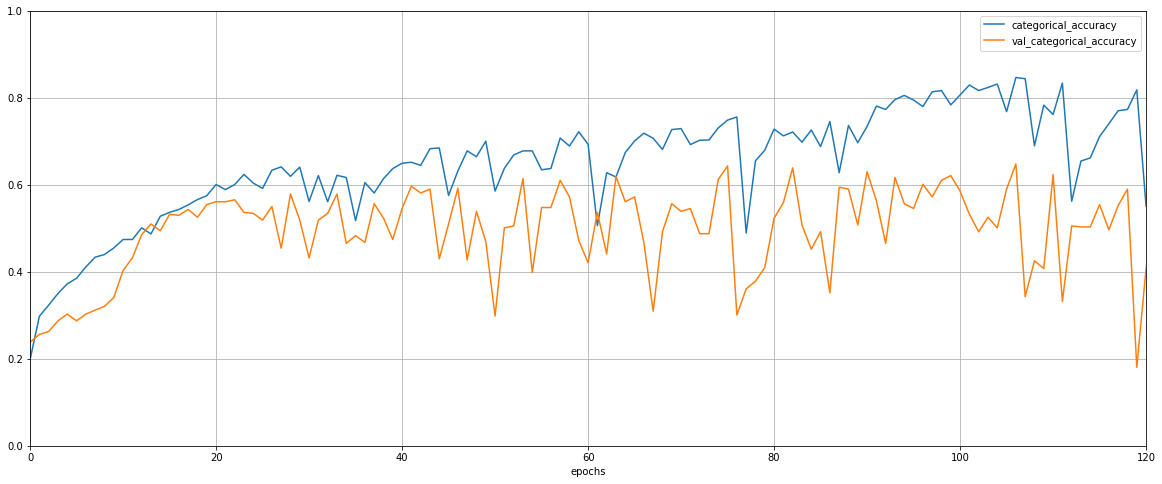

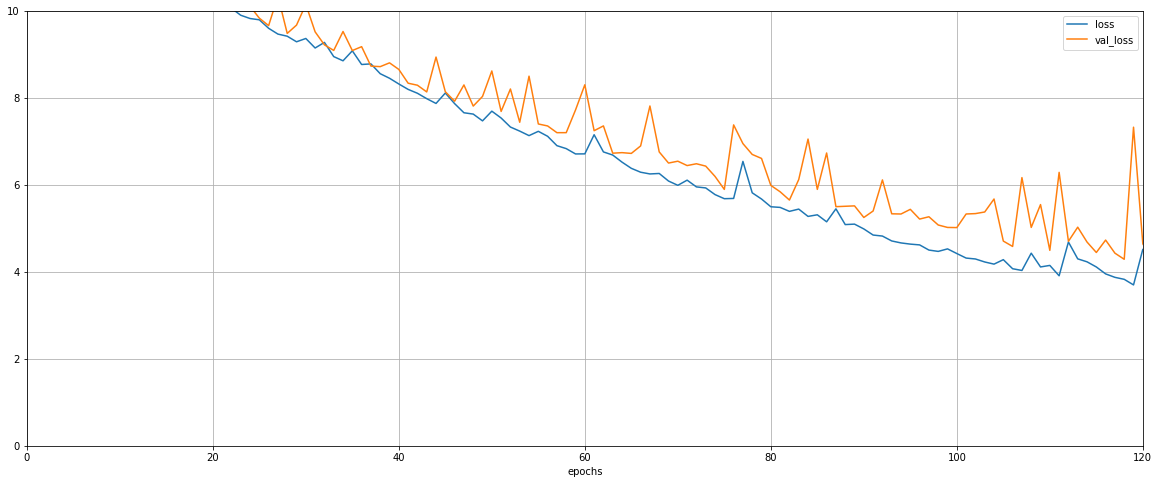

In [57]:
def plot_show(his,label,epochs,min_value,max_value):
    data = {}
    data[label] = his.history[label]
    data['val_'+label] = his.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(20,8))
    plt.grid(True)
    plt.axis([0,epochs,min_value,max_value])
    plt.xlabel("epochs")
    plt.show()
plot_show(his,'categorical_accuracy',120,0,1)
plot_show(his,'loss',120,0,10)

# 第三次执行


In [39]:
import keras

In [41]:
def emo1d(input_shape, num_classes,args):
    model = Sequential(name='Emo1D')

# LFLB1
    model.add(Conv1D(filters = 64,kernel_size = (3),strides=1,padding='same',data_format='channels_last',input_shape=input_shape, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))	
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size = 4, strides = 4))

#LFLB2
    model.add(Conv1D(filters=64, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size = 4, strides = 4))

#LFLB3
    model.add(Conv1D(filters=128, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size = 4, strides = 4))

#LFLB4
    model.add(Conv1D(filters=128, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size = 4, strides = 4))

#LSTM
    model.add(LSTM(units=args.num_fc, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))) 

#FC
    
    model.add(Dense(units=100,activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(Dense(units=7,activation='softmax'))


	
    opt = optimizers.SGD(lr = args.learning_rate, decay=args.decay, momentum=args.momentum, nesterov=True)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model

In [42]:
def train(model, x_tr, y_tr, x_val, y_val, args,his):
    es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=8)
    mc = ModelCheckpoint('best_model_1D_CNN.h5', monitor='val_categorical_accuracy', mode='max',verbose=1,save_best_only=True)
    history = model.fit(x_tr, y_tr, epochs=args.num_epochs, batch_size=args.batch_size, validation_data=(x_val, y_val),
                        callbacks=[es, mc])
    his=history
    return model,his
def test(model,x_t,y_t):

    saved_model = load_model('best_model_1D_CNN.h5')
    score = saved_model.evaluate(x_t,y_t,batch_size=20)
    print(score)
    return score
def loadData1d(x_tr,y_tr,x_t,y_t,x_val,y_val):
    x_tr = x_tr.reshape(-1,x_tr.shape[1],1)
    x_t = x_t.reshape(-1,x_t.shape[1],1)
    x_val = x_val.reshape(-1,x_val.shape[1],1)
    y_tr = to_categorical(y_tr)
    y_t = to_categorical(y_t)
    y_val = to_categorical(y_val)
    return x_tr,y_tr,x_t,y_t,x_val,y_val
class arguments(object):        
        def __init__(self):
                self.num_fc = 256
                self.batch_size = 64
                self.num_epochs = 100 #best model will be saved before number of epochs reach this value
                self.learning_rate = 0.001
                self.decay = 1e-6
                self.momentum = 0.9

In [43]:
#load data	
x_tr,y_tr,x_t,y_t,x_val,y_val = loadData1d(xd_tr,yd_tr,xd_t,yd_t,xd_val,yd_val)	

print(x_tr.shape)
print(x_val.shape)
print(x_t.shape)
args = arguments()

#define model
model = emo1d(input_shape=x_tr.shape[1:],num_classes=len(np.unique(np.argmax(y_tr, 1))),args=args)
model.summary()

his=[]
#train model
model,his = train(model,x_tr,y_tr,x_val,y_val,args=args,his=his)

#test model
score = test(model,x_t,y_t)
def test(x_t,y_t):

    saved_model = model = load_model('./best_model_1D_CNN.h5')
    score = saved_model.evaluate(x_t,y_t,batch_size=60)
    print(score)
    return score

print("Training")
score1 = test(x_tr,y_tr)
print(score1)
print("Validation")
score2 = test(x_val,y_val)
print(score2)
print("Testing")
score3 = test(x_t,y_t)
print(score3)

(1796, 16000, 1)
(449, 16000, 1)
(425, 16000, 1)
Model: "Emo1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_32 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation_32 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 4000, 64)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 4000, 64)          12352     
_________________________________________________________________
batch_normalization_33 (Batc (None, 4000, 64)          256       
_________________________________________________________________
activation_3

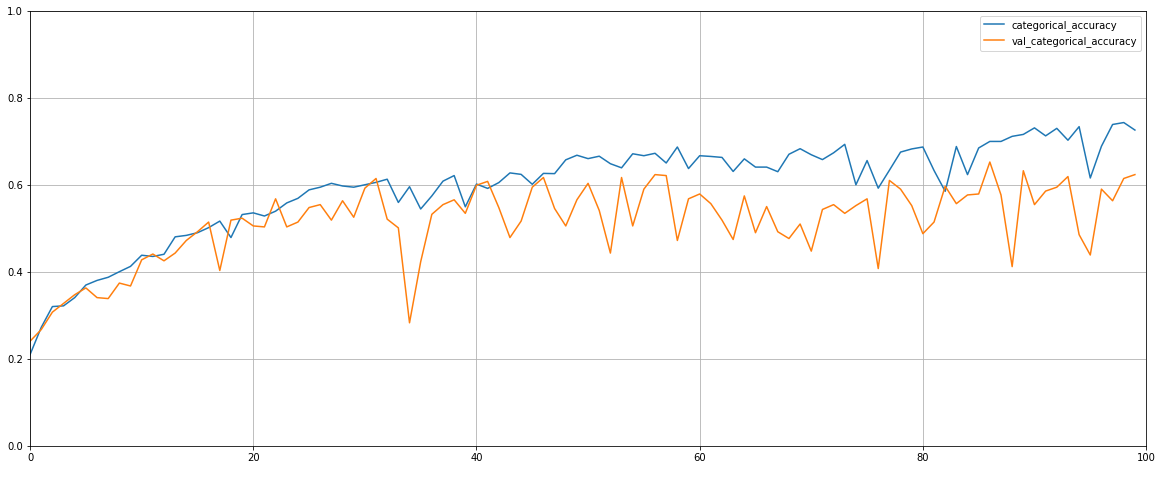

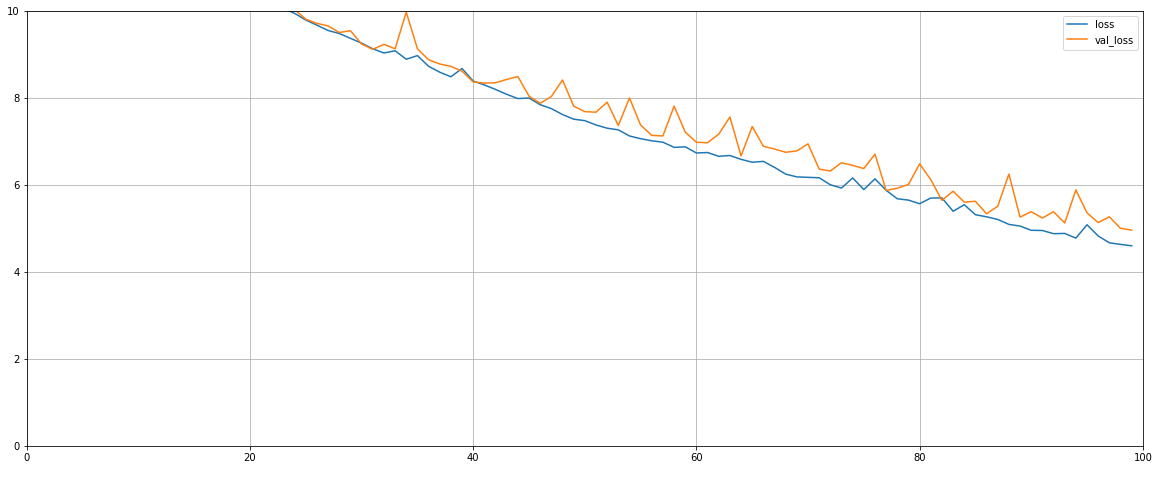

In [44]:
def plot_show(his,label,epochs,min_value,max_value):
    data = {}
    data[label] = his.history[label]
    data['val_'+label] = his.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(20,8))
    plt.grid(True)
    plt.axis([0,epochs,min_value,max_value])
    plt.xlabel("epochs",color="white")
    plt.show()
plot_show(his,'categorical_accuracy',100,0,1)
plot_show(his,'loss',100,0,10)

# 2D CNN LSTM model

In [14]:
pw = 2
def emo2d(input_shape, num_classes,args):
	
	model = Sequential(name='Emo2D')
	print("Hey",input_shape)
	# LFLB1
	model.add(Conv2D(filters = 64,kernel_size = 3,strides=1,padding='same',data_format='channels_last',input_shape=input_shape, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
	model.add(BatchNormalization())
	model.add(Activation('elu'))
	model.add(MaxPooling2D(pool_size = (int(2*pw/2),int(2*pw/2)), strides = int(pw/2),data_format='channels_last'))

	#LFLB2
	model.add(Conv2D(filters=64, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
	model.add(BatchNormalization())
	model.add(Activation('elu'))
	model.add(MaxPooling2D(pool_size = (pw,pw), strides = pw,data_format='channels_last'))

	#LFLB3
	model.add(Conv2D(filters=128, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
	model.add(BatchNormalization())
	model.add(Activation('elu'))
	model.add(MaxPooling2D(pool_size = (pw,pw), strides = pw,data_format='channels_last',))

	# #LFLB4
	model.add(Conv2D(filters=128, kernel_size = 3, strides=1,padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
	model.add(BatchNormalization())
	model.add(Activation('elu'))
	model.add(MaxPooling2D(pool_size = (pw,pw), strides = pw,data_format='channels_last'))

	# Reshape to feed it to LSTM
	model.add(Reshape((-1,1)))

	#LSTM
	model.add(LSTM(units=args.num_fc,return_sequences=False, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
	#FC
	# model.add(Dense(units=100,activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) # increases the accuracy a little more than mentioned in the paper

	model.add(Dense(units=7,activation='softmax'))

	#Model compilation	
	opt = optimizers.SGD(lr = args.learning_rate, decay=args.decay, momentum=args.momentum, nesterov=True)
	model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
	
	return model


In [15]:
def train(model,x_tr,y_tr,x_val,y_val,args):
	
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
	mc = ModelCheckpoint('best_model_2D_CNN.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
	history = model.fit(x_tr,y_tr,epochs=args.num_epochs,batch_size=args.batch_size,validation_data=(x_val,y_val),callbacks=[es, mc])
	return model

def test(model,x_t,y_t):

	saved_model = load_model('best_model_2D_CNN.h5')
	score = saved_model.evaluate(x_t,y_t,batch_size=120)
	print(score)
	return score

def loadData2d(xd_tr,yd_tr,xd_t,yd_t,xd_val,yd_val):

	x_tr = []
	x_val = []
	x_t = []
	sr = 16000
	for a in xd_tr:
		S = librosa.feature.melspectrogram(y=a, sr=sr)
		x_tr.append(librosa.power_to_db(S, ref=np.max))
	
	for a in xd_val:
		S = librosa.feature.melspectrogram(y=a, sr=sr)
		x_val.append(librosa.power_to_db(S, ref=np.max))
	for a in xd_t:
		S = librosa.feature.melspectrogram(y=a, sr=sr)
		x_t.append(librosa.power_to_db(S, ref=np.max))

	x_tr,x_t,x_val = np.array(x_tr),np.array(x_t),np.array(x_val)

	x_tr = x_tr.reshape(-1,x_tr.shape[1],x_tr.shape[2],1)
	x_t = x_t.reshape(-1,x_t.shape[1],x_t.shape[2],1)
	x_val = x_val.reshape(-1,x_val.shape[1],x_val.shape[2],1)
	y_tr = to_categorical(yd_tr)
	y_t = to_categorical(yd_t)
	y_val = to_categorical(yd_val)
	return np.array(x_tr),y_tr,np.array(x_t),y_t,np.array(x_val),y_val

class arguments(object):        
		def __init__(self):
				self.num_fc = 256
				self.batch_size = 5
				self.num_epochs = 2 #best model will be saved before number of epochs reach this value
				self.learning_rate = 1
				self.decay = 1e-6
				self.momentum = 0.9

In [16]:
#load data	
x_tr,y_tr,x_t,y_t,x_val,y_val = loadData2d(xd_tr,yd_tr,xd_t,yd_t,xd_val,yd_val)	

print(x_tr.shape)
print(x_val.shape)
print(x_t.shape)

args = arguments()

#define model
model = emo2d(input_shape=x_tr.shape[1:],num_classes=len(np.unique(np.argmax(y_tr, 1))),args=args)
model.summary()

# #train model
model = train(model,x_tr,y_tr,x_val,y_val,args=args)

# #test model
score = test(model,x_t,y_t)
def test(model,x_t,y_t):

	saved_model = load_model('./best_model_2D_CNN.h5')
	score = saved_model.evaluate(x_t,y_t,batch_size=128)
	print(score)
	return score

#test model
print("Training")
score = test(model,x_tr,y_tr)
print("Validation")
score = test(model,x_val,y_val)
print("Testing")
score = test(model,x_t,y_t)

(1796, 128, 32, 1)
(449, 128, 32, 1)
(425, 128, 32, 1)
Hey (128, 32, 1)
Model: "Emo2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 32, 64)       640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 32, 64)       256       
_________________________________________________________________
activation_4 (Activation)    (None, 128, 32, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 31, 64)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 127, 31, 64)       36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 127, 31, 64)       256       
_______________________________________________________

In [17]:
model = load_model('best_model_2D_CNN.h5')

predict = np.argmax(np.array(model.predict(x_tr)),axis = 1)
actual = np.array(yd_tr,dtype = np.dtype(np.int8))
print("Confusion Matrix:")
print(confusion_matrix(actual,predict))

Confusion Matrix:
[[414   0   0   0   0   0   0]
 [272   0   0   0   0   0   0]
 [204   0   0   0   0   0   0]
 [179   0   0   0   0   0   0]
 [214   0   0   0   0   0   0]
 [280   0   0   0   0   0   0]
 [233   0   0   0   0   0   0]]
